In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.model_selection import train_test_split

import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

# Now you can read the CSV file
df = pd.read_csv('tweets.csv')


In [3]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
df.shape

(27481, 4)

In [5]:
#Convert sentiment to numerical values
df.replace({'sentiment':{'positive':1}}, inplace=True)
df.replace({'sentiment':{'negative':0}}, inplace=True)
df.replace({'sentiment':{'neutral':-1}}, inplace=True)

# Again checking class distribution of target column
df['sentiment'].value_counts()

sentiment
-1    11118
 1     8582
 0     7781
Name: count, dtype: int64

In [6]:
# Removing the Neutral Sentiment Tweets
df = df[df['sentiment'] != -1]

In [7]:
# Again checking class distribution of target column
df['sentiment'].value_counts()

sentiment
1    8582
0    7781
Name: count, dtype: int64

In [8]:
#Let's drop selected text & text id column
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True) #Resetting the index
original_df = df.copy(deep=True)
df.head()

,text,sentiment
0,Sooo SAD I will miss you here in San Diego!!!,0
1,my boss is bullying me...,0
2,what interview! leave me alone,0
3,"Sons of ****, why couldn`t they put them on t...",0
4,2am feedings for the baby are fun when he is a...,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16363 entries, 0 to 16362
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       16363 non-null  object
 1   sentiment  16363 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 255.8+ KB


In [10]:
#Descriptive summary of dataset
df.describe()

,sentiment
count,16363.000000
mean,0.524476
std,0.499416
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
df.isnull().sum()
#Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()
#Let's check Null values
df.isnull().sum()
#Let's check Duplicates
df.duplicated().sum()

0

In [12]:
# Drop the corresponding text column for 'neutral' sentiment
# df = df[df['sentiment'] != 'neutral' ]

In [13]:
# df[target].value_counts()

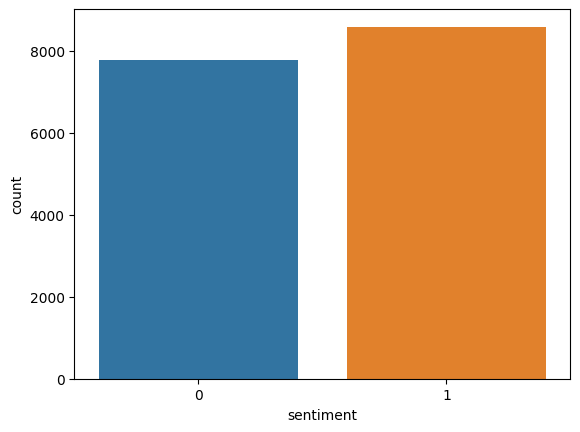

In [14]:
sns.countplot(x=df['sentiment'])
plt.show()

In [15]:
# Let's get a word count 
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['text','word_count']].head()

,text,word_count
0,Sooo SAD I will miss you here in San Diego!!!,11
1,my boss is bullying me...,5
2,what interview! leave me alone,6
3,"Sons of ****, why couldn`t they put them on t...",15
4,2am feedings for the baby are fun when he is a...,14


In [16]:
#Number of Characters- including spaces
df['char_count'] = df['text'].str.len() # this also includes spaces
df[['text','char_count']].head()

,text,char_count
0,Sooo SAD I will miss you here in San Diego!!!,46
1,my boss is bullying me...,25
2,what interview! leave me alone,31
3,"Sons of ****, why couldn`t they put them on t...",75
4,2am feedings for the baby are fun when he is a...,64


In [17]:
# nltk.download('stopwords')  
# #Import the english stop words list from NLTK
# stopwords_english = stopwords.words('english')
# print('Stop words\n')
# print(stopwords_english)
# print('\nPunctuation\n')
# print(string.punctuation)

In [18]:
# Creates an instance of the PorterStemmer.
port_stem = PorterStemmer()

# Define the Stemming Function and perform operations 
def stemming(content):
    # Remove non-alphabetic characters using regular expression
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    
    # Convert to lowercase
    stemmed_content = stemmed_content.lower()
    
    # Tokenize the text into words
    stemmed_content = stemmed_content.split()
    
    # Apply stemming using Porter Stemmer, and exclude stopwords
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    
    # Join the stemmed words into a single string
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

# Applies the stemming function to the 'text' column of the DataFrame and creates a new column 'stemmed_content' containing the preprocessed text.
df['stemmed_content'] = df['text'].apply(stemming)


In [19]:
# Now you can read the CSV file
# df = pd.read_csv('Pre-processed_Tweets.csv')

In [20]:
df.head()

,text,sentiment,word_count,char_count,stemmed_content
0,Sooo SAD I will miss you here in San Diego!!!,0,11,46,sooo sad miss san diego
1,my boss is bullying me...,0,5,25,boss bulli
2,what interview! leave me alone,0,6,31,interview leav alon
3,"Sons of ****, why couldn`t they put them on t...",0,15,75,son put releas alreadi bought
4,2am feedings for the baby are fun when he is a...,1,14,64,feed babi fun smile coo


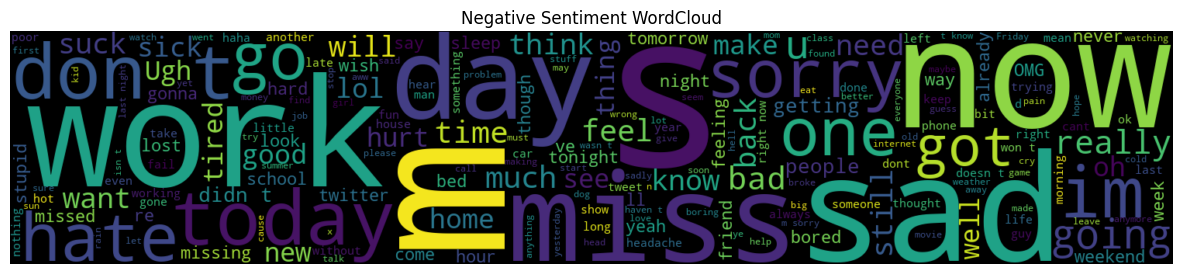

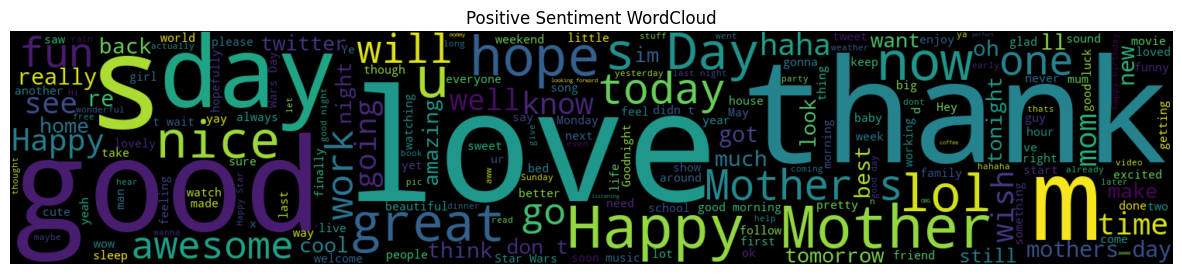

In [21]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 0]
positive_df = df[df['sentiment'] == 1]

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black', 
                          width=1500, height=300).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')

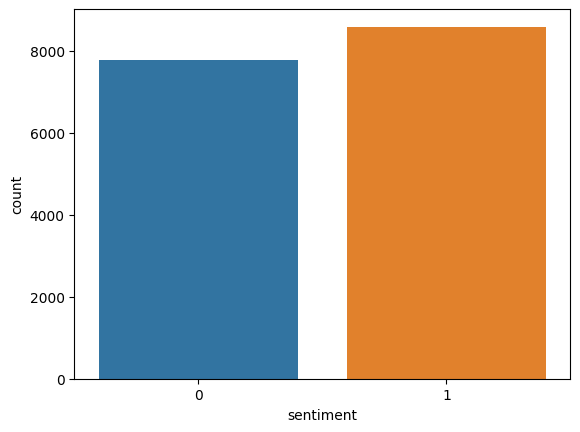

In [22]:
sns.countplot(x=df['sentiment'])
plt.show()

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# Create a list of processed tweets from df
processed_tweets_train = df['stemmed_content'].tolist()

# Create a CountVectorizer to extract unique words
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(processed_tweets_train)

# Get the unique words
words = vectorizer.get_feature_names_out()

In [24]:
# Print the count of unique words
print("Count of unique words:", len(words))

print(words[0:1000])

Count of unique words: 14102
['aaaa' 'aaaaaaaaaahhhhhhhh' 'aaaaaaaaaamaz' 'aaaaaaaafternoon' 'aaaaall'
 'aaaaaoouoouoouu' 'aaaaarrrrggghhh' 'aaaaawhh' 'aaaaawwwwwww'
 'aaaagggessss' 'aaaagh' 'aaaah' 'aaaahh' 'aaaaiieee' 'aaaau' 'aaaaw'
 'aaah' 'aaahaha' 'aaahhh' 'aaand' 'aaargh' 'aaarrrgggghhh' 'aaarrrggghhh'
 'aaarrrgh' 'aaaw' 'aaawww' 'aah' 'aam' 'aapko' 'aargh' 'aaron' 'aarrgghh'
 'aasman' 'ab' 'aba' 'abalon' 'abandon' 'abang' 'abba' 'abbey' 'abbi'
 'abbrevi' 'abbster' 'abc' 'abean' 'abhi' 'abhor' 'abi' 'abid' 'abil'
 'abit' 'abl' 'abnorm' 'aboard' 'about' 'abouttttto' 'abp' 'abroad'
 'absent' 'absolut' 'absolutley' 'absolutli' 'absoulutley' 'abstract'
 'abt' 'abuelo' 'abueltia' 'abund' 'abus' 'abuzz' 'ac' 'acaban' 'academ'
 'academi' 'acc' 'accadent' 'accdentt' 'accela' 'acceler' 'accent'
 'accept' 'access' 'accessori' 'accid' 'accident' 'accidentali'
 'accompani' 'accomplish' 'accord' 'accordion' 'account' 'acct' 'accumul'
 'accus' 'ace' 'ach' 'achi' 'achiev' 'achilli' 'acid' 'ack

In [25]:
# Filter data for negative sentiment with value 0 and positive sentiment
negative_sentiment = df[df['sentiment'] == 0].head(1000)
positive_sentiment = df[df['sentiment'] == 1].head(1000)

# Concatenate the balanced dataframes
balanced_data = pd.concat([negative_sentiment, positive_sentiment])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (X) and target (y)
X = balanced_data['stemmed_content']
y = balanced_data['sentiment']


In [26]:
import pandas as pd

# Assuming balanced_data is a DataFrame and 'stemmed_content' and 'sentiment' are columns in that DataFrame

# Create a new DataFrame with 'stemmed_content' and 'sentiment' columns
new_dataframe = pd.DataFrame({
    'stemmed_content': balanced_data['stemmed_content'],
    'sentiment': balanced_data['sentiment']
})

# Separate features (X) and target (y) from the new DataFrame
X = new_dataframe['stemmed_content']
y = new_dataframe['sentiment']


In [27]:

# Extract the 'stemmed_content' column from  the DataFrame
text_column = df['stemmed_content'].head(2000)

# Initialize an empty list to store words
words_list = []

# Loop through each sentence in the 'text' column
for sentence in text_column:
    # Split the sentence into words
    words = sentence.split()
    # Extend the list of words
    words_list.extend(words)

# Convert the list to a set to remove duplicates, then back to a list
unique_words_list = list(set(words_list))

# Count the number of unique words
num_unique_words = len(unique_words_list)

print("Number of unique words:", num_unique_words)
print("List of unique words:", unique_words_list)

Number of unique words: 3900
List of unique words: ['europ', 'haiaa', 'whit', 'zealand', 'gaze', 'sesam', 'banksvil', 'dnd', 'either', 'eep', 'utter', 'pomona', 'ranch', 'coincid', 'fwiend', 'bonjour', 'home', 'handl', 'ixigo', 'nar', 'term', 'uncontrol', 'sunshin', 'liao', 'within', 'chicken', 'seth', 'nakaka', 'stuck', 'proud', 'lifecam', 'privat', 'pant', 'hmmm', 'prefer', 'ahaha', 'simfing', 'loner', 'husband', 'mojokin', 'audit', 'colin', 'omfg', 'sparkler', 'reach', 'littl', 'tmh', 'apuya', 'thee', 'crrrrrazi', 'barcelona', 'treatment', 'whatev', 'divo', 'dec', 'eeeeep', 'kyle', 'haha', 'tweeti', 'linux', 'sauc', 'libertin', 'learn', 'said', 'launch', 'august', 'nose', 'damn', 'lion', 'hemp', 'havent', 'staffer', 'process', 'debit', 'outlet', 'juss', 'bibl', 'cabl', 'hol', 'careless', 'kap', 'beat', 'htm', 'kitchen', 'presenc', 'pelzer', 'whisk', 'devo', 'eather', 'sexual', 'blogrol', 'mile', 'forgotten', 'journey', 'hah', 'visibl', 'gn', 'pup', 'sr', 'coo', 'te', 'dear', 'aim', 

In [28]:
# # Initialize an empty list to store binary arrays for each row
# bin_arrays = []

# # Iterate through each row
# for sentence in text_column:
#     # Initialize an empty array for the current row
#     row_array = []
#     # Split the sentence into words
#     words = sentence.split()
#     # Iterate through each unique word
#     for unique_word in unique_words_list:
#         # If the unique word is in the sentence, set to 1, else set to 0
#         if unique_word in words:
#             row_array.append(1)
#         else:
#             row_array.append(0)
#     # Append the binary array for the current row to the list
#     bin_arrays.append(row_array)

# # Display the row arrays
# for i, row_array in enumerate(bin_arrays):
#     print("Row {}: {}".format(i+1, row_array))

# # Get the length of the resulting row_arrays
# length_result = len(bin_arrays)
# print("Length of the resulting row_arrays:", length_result)

In [29]:
X = new_dataframe['stemmed_content']
y = new_dataframe['sentiment']


In [30]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into training and testing sets, maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [31]:
X_train,X_test,y_train,y_test

(1259            go miss roomi longer roomi start tomorrow
 1739                            two hilaaaaari love verna
 1436                                                 suck
 1809          awesom headin nite grad dinner c u boi hehe
 1690                     thank song awesom sing along day
                               ...                        
 952     write music lit final paper mozart ein klein n...
 1759    wish blog work properli great followfriday blo...
 1306                                            bore noth
 590                                     phatass hope meet
 480                    reec naw miss video cool look sexi
 Name: stemmed_content, Length: 1600, dtype: object,
 1145    sadden youtub chang like everi youtub kid use ...
 1652                                     freez math class
 1989                                friday treat well far
 1139    oy im nerd im writin cuz followin mean lik sum...
 1445    almost die laptop screen set bright reinstal w...
   

In [32]:
# # Define a function to create binary arrays for each tweet
# def create_binary_arrays(tweets, unique_words):
#     stemmer = PorterStemmer()
#     binary_arrays = []

#     for tweet in tweets:
#         binary_array = [1 if stemmer.stem(word) in tweet else 0 for word in unique_words]
#         binary_arrays.append(binary_array)

#     return binary_arrays

# # Get the unique words
# unique_words = unique_words_list

# # Create binary arrays for X_train
# arrays_train = create_binary_arrays(X_train, unique_words)

# # Create binary arrays for X_test
# binary_arrays_test = create_binary_arrays(X_test, unique_words)

# # Create a dataframe with the binary arrays for each word
# binary_train_df = pd.DataFrame(arrays_train, columns=unique_words)

# # Create a dataframe with the binary arrays for each word
# binary_test_df = pd.DataFrame(binary_arrays_test, columns=unique_words)

In [33]:
# # Saving the binary_train_df and binary_test_df to csv files
# binary_train_df.to_csv("binary_train_df.csv", index=False)
# binary_test_df.to_csv("binary_test_df.csv", index=False)

In [34]:
binary_train_df=pd.read_csv('binary_train_df.csv')
binary_test_df=pd.read_csv('binary_test_df.csv')

In [43]:
binary_train_df

,sharpi,endang,journey,oot,mayo,join,er,neeed,buy,th,...,dh,right,oop,muscl,goooooooooooood,girl,star,ef,seat,ok
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1596,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1597,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
y_train

1259    0
1739    1
1436    0
1809    1
1690    1
       ..
952     1
1759    1
1306    0
590     1
480     1
Name: sentiment, Length: 1600, dtype: int64

In [45]:
# Convert binary_train_df to a 2D NumPy array
# X_train_array=X_train.iloc[1600:]
X_train_array = binary_train_df.values

#Convert binary_test_df to a 2D NumPy array
X_test_array = binary_test_df.values
# Now X_train_array is a 2D array that you can pass to your logistic regression function
print(X_train_array)
X_train_array.shape


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


(1600, 3900)

In [47]:
X_train_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [48]:
print(X_test_array)
X_test_array.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(400, 3900)

In [49]:
# import pandas as pd

# # Read the CSV file into a DataFrame
# binary_train_df = pd.read_csv("binary_train_df.csv")

# # Access only the first 1600 rows of the DataFrame
# X_train_array = binary_train_df.values[:1600]

# # Print the resulting array
# print(X_train_array)
# print(X_train_array.shape)

In [50]:
# Print the row of binary_train_df
print(binary_train_df.iloc[0].value_counts())

0
0    3872
1      28
Name: count, dtype: int64


In [51]:
X.shape,y.shape

((2000,), (2000,))

In [52]:
y_train_array = np.array(y_train)  # Convert y_train to a numpy array
y_test_array=np.array(y_test)

In [53]:
print("X_train_array shape:", X_train_array.shape)
print("y_train_array shape:", y_train_array.shape)
print("X_test_array shape:",X_test_array.shape)
print("y_test_array shape:",y_test_array.shape)

X_train_array shape: (1600, 3900)
y_train_array shape: (1600,)
X_test_array shape: (400, 3900)
y_test_array shape: (400,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegressionBinary:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None
        self.cost_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Convert input data to NumPy arrays
        X = np.array(X)
        y = np.array(y)

        # Verify X and y dimensions
        if len(X.shape) != 2 or len(y.shape) != 1:
            raise ValueError("Input data must be 2D array for features and 1D array for target")

        m, n = X.shape  # Number of samples and features
        self.theta = np.zeros(n)

        for i in range(self.n_iterations):
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)
            error = h - y
            gradient = np.dot(X.T, error) / m
            self.theta -= self.learning_rate * gradient

            # Compute and store cost
            cost = self._compute_cost(h, y)
            self.cost_history.append(cost)

            # Print cost after every 100 iterations
            if (i + 1) % 1000 == 0:
                print(f"Iteration {i+1}, Cost: {cost}")

    def _compute_cost(self, h, y):
        m = len(y)
        cost = (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost

    def predict(self, X):
        z = np.dot(X, self.theta)
        h = self.sigmoid(z)
        return (h >= 0.5).astype(int)

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y) * 100
        
    def plot_cost_history(self):
        plt.plot(range(self.n_iterations), self.cost_history)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Cost vs Iteration')
        plt.show()

# Initialize and fit the logistic regression model
logistic_model = LogisticRegressionBinary(learning_rate=0.1, n_iterations=10000)
logistic_model.fit(X_train_array, y_train_array)

# Calculate accuracy
accuracy = logistic_model.accuracy(X_train_array, y_train_array)
print("Train_Accuracy:", accuracy)


Iteration 1000, Cost: 0.3651239569996281


In [ ]:
# logistic_model = LogisticRegressionBinary(learning_rate=0.1, n_iterations=2000)
# logistic_model.fit(X_test_array, y_test_array)

# # Calculate accuracy
# accuracy = logistic_model.accuracy(X_test_array, y_test_array)
# print("Test_Accuracy:", accuracy)


In [ ]:
def plot_cost_history(self):
        plt.plot(range(self.n_iterations), self.cost_history)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Cost vs Iteration')
        plt.show()
# Plot cost vs iteration
logistic_model.plot_cost_history()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to make predictions
def predict(X, theta):
    z = np.dot(X, theta)
    h = 1 / (1 + np.exp(-z))
    return (h >= 0.5).astype(int)


# Make predictions on training data
y_train_pred = predict(X_train_array, logistic_model.theta)

# Print metrics for training data
print("Metrics on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred) * 100}")
print(f"Precision: {precision_score(y_train, y_train_pred)}")
print(f"Recall: {recall_score(y_train, y_train_pred)}")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}")

# # Make predictions on test data
# y_test_pred = predict(X_test_array, logistic_model.theta)

# # Print metrics for test data
# print("\n Results on Test Data:")
# print(f"Accuracy: {accuracy_score(y_test, y_test_pred) * 100}")
# print(f"Precision: {precision_score(y_test, y_test_pred)}")
# print(f"Recall: {recall_score(y_test, y_test_pred)}")
# print(f"F1 Score: {f1_score(y_test, y_test_pred)}")


In [ ]:
logistic_model = LogisticRegressionBinary(learning_rate=0.1, n_iterations=2000)
logistic_model.fit(X_test_array, y_test_array)

# Calculate accuracy
accuracy = logistic_model.accuracy(X_test_array, y_test_array)
print("Test_Accuracy:", accuracy)


In [ ]:
# Make predictions on test data
y_test_pred = predict(X_test_array, logistic_model.theta)

# Print metrics for test data
print("\n Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred) * 100}")
print(f"Precision: {precision_score(y_test, y_test_pred)}")
print(f"Recall: {recall_score(y_test, y_test_pred)}")
print(f"F1 Score: {f1_score(y_test, y_test_pred)}")